In [1]:
import numpy as np
import pandas as pd

path = '/data/examples/may_the_4_be_with_u/where_am_i/'

# make a label map
df = pd.read_csv(path + 'mapping.txt', header=None)
yMap = dict(zip(df[0], df[1]))
print(len(yMap), yMap)

15 {'CALsuburb': 9, 'PARoffice': 7, 'bedroom': 12, 'coast': 10, 'forest': 4, 'highway': 14, 'industrial': 2, 'insidecity': 3, 'kitchen': 0, 'livingroom': 5, 'mountain': 8, 'opencountry': 6, 'store': 11, 'street': 1, 'tallbuilding': 13}


In [2]:
import os

# show file structure
for dirname, dirnames, filenames in os.walk(path+'train'):    
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/data/examples/may_the_4_be_with_u/where_am_i/train/CALsuburb/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/PARoffice/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/bedroom/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/coast/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/forest/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/highway/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/industrial/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/insidecity/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/kitchen/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/livingroom/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/mountain/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/opencountry/image_0001.jpg
/data/examples/may_the_4_be_with_u/where_am_i/train/store/image_0001.jpg
/data/exampl

In [3]:
import os
import pandas as pd

#make a image table
trainList = []
for dirname, dirnames, filenames in os.walk(path+'train'):    
    for filename in filenames:
        folderName = os.path.split(dirname)[-1]
        #print(os.path.join(dirname, filename), folderName)        
        row = []
        row.append(yMap[folderName])
        row.append(folderName)
        row.append(filename)
        row.append(os.path.join(dirname, filename))
        trainList.append(row)        
        
trainDf = pd.DataFrame(trainList, columns=['label','folder','file','path'])          
print(trainDf.shape)

(2985, 4)


In [4]:
trainDf.head()

,label,folder,file,path
0,9,CALsuburb,image_0001.jpg,/data/examples/may_the_4_be_with_u/where_am_i/...
1,9,CALsuburb,image_0002.jpg,/data/examples/may_the_4_be_with_u/where_am_i/...
2,9,CALsuburb,image_0003.jpg,/data/examples/may_the_4_be_with_u/where_am_i/...
3,9,CALsuburb,image_0004.jpg,/data/examples/may_the_4_be_with_u/where_am_i/...
4,9,CALsuburb,image_0005.jpg,/data/examples/may_the_4_be_with_u/where_am_i/...


img.shape (220, 330, 3)
color: [48 48 48]


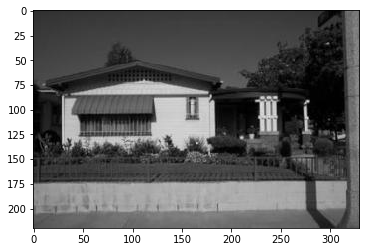

In [5]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

# examine a image
img = cv2.imread(trainDf['path'][0]) 
plt.imshow(img) #, cmap='gray'
print('img.shape',img.shape)
print('color:',img[0][0])


In [6]:
import cv2
import numpy as np
resize = (224, 224)

#圖片變數值資料
X = np.array([cv2.resize(cv2.imread(file), resize) for file in trainDf['path']])

#normalize X
print(X[0][0][0])
X = X.astype('float32')
X /= 255.
print(X[0][0][0])



[48 48 48]
[ 0.1882353  0.1882353  0.1882353]


In [7]:
#one hot encoding Y
import keras

num_classes = 15
label = keras.utils.to_categorical(trainDf['label'], num_classes)

print(label.shape)

Using TensorFlow backend.


(2985, 15)


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, label, test_size=0.33) #default就會shuffle, 不用random_state=42

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)
print(x_train[0][0][0])
print(y_train[0:5])

(1999, 224, 224, 3) (1999, 15) (986, 224, 224, 3) (986, 15)
[ 0.49019608  0.49019608  0.49019608]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


選擇Model開始

In [9]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import os

# build our CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      18496     
__________

In [10]:

# initiate Adam optimizer
opt = keras.optimizers.Adam()
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [11]:
# Use ModelCheckpoint to save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_trained_model.h5'
print(save_dir)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

try:    
    modelBest = load_model(model_path)
    if modelBest is not None:
        print('modelBest',modelBest)
        #scores = modelBest.evaluate(x_test, y_test, verbose=1)
        print('modelBest loss:', scores[0])
        print('modelBest accuracy:', scores[1])   
except Exception as error:
    print('Caught this error: ' + repr(error))
    
    

/home/jovyan/murphy/where_am_i/saved_models
modelBest <keras.models.Sequential object at 0x7fb86a2ce9b0>
Caught this error: NameError("name 'scores' is not defined",)


In [12]:
batch_size = 32
epochs = 50

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Fit the model on the batches generated by datagen.flow().

isSaveModel = True
modelBest = None
if isSaveModel:
    model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4,
                    callbacks=[earlystop, checkpoint])
    
    # loading our save model
    print("Loading trained model ", model_path)
    modelBest = load_model(model_path)

else:
    model_history = model.fit_generator(datagen.flow(x_train, y_train,
                         batch_size=batch_size),
            epochs=epochs,
            validation_data=(x_test, y_test),
            workers=4)


if modelBest is not None:
    print('modelBest',modelBest)
    scores = modelBest.evaluate(x_test, y_test, verbose=1)
    print('modelBest loss:', scores[0])
    print('modelBest accuracy:', scores[1])

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


(1999, 224, 224, 3) (1999, 15) (986, 224, 224, 3) (986, 15)
Using real-time data augmentation.
Epoch 1/50
62/63 [============================>.] - ETA: 0s - loss: 2.7810 - acc: 0.1226
Epoch 00001: val_loss improved from inf to 2.45496, saving model to /home/jovyan/murphy/where_am_i/saved_models/keras_trained_model.h5
63/63 [==============================] - 29s 455ms/step - loss: 2.7763 - acc: 0.1231 - val_loss: 2.4550 - val_acc: 0.1531
Epoch 2/50
62/63 [============================>.] - ETA: 0s - loss: 2.4082 - acc: 0.2070
Epoch 00002: val_loss improved from 2.45496 to 2.27075, saving model to /home/jovyan/murphy/where_am_i/saved_models/keras_trained_model.h5
63/63 [==============================] - 37s 590ms/step - loss: 2.4051 - acc: 0.2072 - val_loss: 2.2708 - val_acc: 0.2606
Epoch 3/50
62/63 [============================>.] - ETA: 0s - loss: 2.2548 - acc: 0.2644
Epoch 00003: val_loss improved from 2.27075 to 2.07209, saving model to /home/jovyan/murphy/where_am_i/saved_models/kera

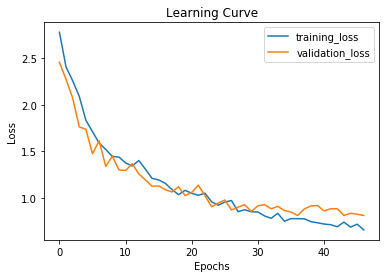

In [13]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [14]:
import os
import pandas as pd

testList = []
for dirname, dirnames, filenames in os.walk(path+'testset'):    
    for filename in filenames:
        row = []
        row.append(filename.replace('.jpg',''))
        row.append(os.path.join(dirname, filename))
        testList.append(row)
        
testDf = pd.DataFrame(testList, columns=['id','path'])        
  
print(testDf.shape, testDf.iloc[0,0], testDf.iloc[0,1])

(1500, 2) 001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf8c7115f5eb033bc3d2 /data/examples/may_the_4_be_with_u/where_am_i/testset/001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf8c7115f5eb033bc3d2.jpg


In [15]:
testDf.head()

,id,path
0,001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf...,/data/examples/may_the_4_be_with_u/where_am_i/...
1,00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570...,/data/examples/may_the_4_be_with_u/where_am_i/...
2,003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369...,/data/examples/may_the_4_be_with_u/where_am_i/...
3,013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...,/data/examples/may_the_4_be_with_u/where_am_i/...
4,0175d5cda7ae5f6767187eef4bc29e0be62a5506acfdcf...,/data/examples/may_the_4_be_with_u/where_am_i/...


In [16]:
imgTest = np.array([cv2.resize(cv2.imread(t), resize) for t in testDf['path']])
print(imgTest[0][0][0])
imgTest = imgTest.astype('float32')
imgTest /= 255.
print(imgTest[0][0][0])
y_pred=model.predict_classes(imgTest)

print(y_pred.shape)

[253 253 253]
[ 0.99215686  0.99215686  0.99215686]
(1500,)


In [17]:
out = pd.DataFrame()
out['id'] = testDf['id']
out['class'] = y_pred
print(out.shape)
out.to_csv('submit.csv',index=False)

(1500, 2)
